Authors: Rocio Kiman and Tonima Tasnim Ananna under the supervision of Erik Tollerud and Adrian Price-Whelan.

In [7]:
from astropy.modeling import models, fitting
import numpy as np
import scipy.stats
import emcee
import corner
import matplotlib.pyplot as plt
rnd = np.random.RandomState(seed=827)

In [4]:
#line = models.Gaussian1D()
#line.stddev.prior = scipy.stats.uniform(-3,6)
#line.mean.prior = scipy.stats.norm(3, 4)
#line.amplitude.prior = scipy.stats.norm(7,4)
#line.noise_model = scipy.stats.norm()
#line.noise_model = scipy.stats.poisson(3)
#line.mean_model_index = 2
#priors = [line.amplitude.prior, line.mean.prior, line.stddev.prior]

In [3]:
n_data=50
amp_true=4.
mean_true=2.5
stddv_true=1.5

In [4]:
# Generate fake data
x = rnd.uniform(-10, 10., n_data)
real_model = models.Gaussian1D(amplitude=amp_true, mean=mean_true, stddev=stddv_true)
y=real_model(x)
yerr=rnd.normal(0,0.5,n_data)
y+=yerr

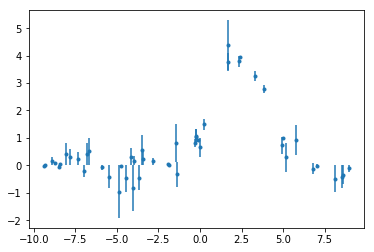

In [5]:
plt.errorbar(x, y, yerr=yerr, fmt='.')
plt.show()

In [8]:
model_gauss = models.Gaussian1D()
fitter_gauss = fitting.LevMarLSQFitter()
best_fit_gauss = fitter_gauss(model_gauss, x, y, weights=1/yerr**2)

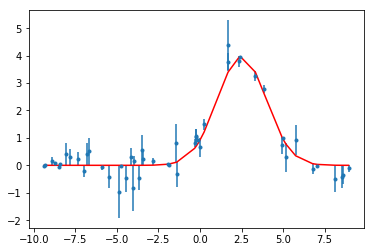

In [10]:
x_sorted = np.sort(x)
plt.errorbar(x, y, yerr=yerr, fmt='.')
plt.plot(x_sorted, best_fit_gauss(x_sorted), '-r')
plt.show()

In [11]:
print(best_fit_gauss)

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean              stddev      
    ------------------ ------------------ ------------------
    3.9697180444501776 2.5130257006315184 1.4707347274405662


In [12]:
def calc_reduced_chi_square(fit, x, y, yerr, N, n_free):
    '''
    fit (array) values for the fit
    x,y,yerr (arrays) data
    N total number of points
    n_free number of parameters we are fitting
    '''
    return 1.0/(N-n_free)*sum(((fit - y)/yerr)**2)

In [13]:
reduced_chi_squared = calc_reduced_chi_square(best_fit_gauss(x), x, y, yerr, len(x), 3)
print('Reduced Chi Squared using astropy.modeling: {}'.format(reduced_chi_squared))

Reduced Chi Squared using astropy.modeling: 1.1494140198921776


In [138]:
prior_amp.pdf(3.5)

0.25

In [137]:
prior_amp = scipy.stats.uniform(3,4)
prior_mean = scipy.stats.uniform(2, 4)
prior_stddev = scipy.stats.uniform(0,3)
priors = [prior_amp, prior_mean, prior_stddev]

line_noise_model = scipy.stats.norm()

def lnprior(params):
    num_param=len(params)
    prob=0
    for i in range(num_param):
        prob+=np.log(priors[i].pdf(params[i]))
    return prob

def lnlike(params, x, y, yerr):
    amp, mean, stddev = params
    line.amplitude = amp
    line.mean = mean
    line.stddev = stddev
    y_mod = line(x)

    scaled_y_diff = (y-y_mod)/yerr 
    result = np.sum(np.log(line_noise_model.pdf(scaled_y_diff)))
    
    return result

#posterior probability:
def lnprob(params, x, y, yerr):
    lp = lnprior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(params, x, y, yerr)

In [121]:
#emcee
line = models.Gaussian1D()
ndim, nwalkers = 3, 20
pos=np.full(ndim*nwalkers, 1.25).reshape(nwalkers,ndim)
pos[:,0]=rnd.uniform(3, 5, nwalkers) #amplitude
pos[:,1]=rnd.uniform(0, 4, nwalkers) #mean
pos[:,2]=rnd.uniform(1, 2, nwalkers) #standard deviation

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[x, y, yerr])

In [122]:
result = sampler.run_mcmc(pos, 500)[0]

/Users/rociokiman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
/Users/rociokiman/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/rociokiman/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


In [123]:
sampler

In [124]:
len(sampler.chain[:,0,0])

20

In [125]:
len(sampler.chain[0,:,0])

500

In [126]:
len(sampler.chain[0,0,:])

3

In [127]:
sampler.chain[:,:,0].shape

(20, 500)

In [128]:
sampler.chain[:,:,0].T.shape

(500, 20)

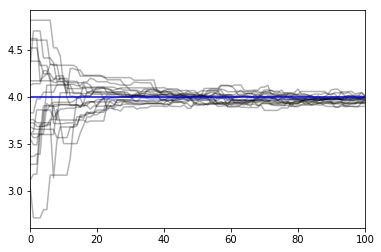

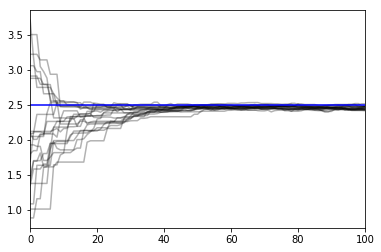

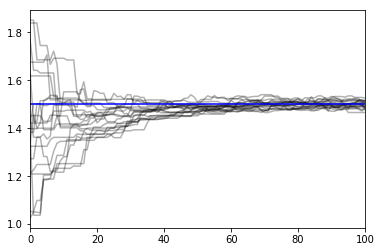

In [129]:
plt.plot(sampler.chain[:,:,0].T, '-', color='k', alpha=0.3)
plt.axhline(amp_true, color='blue')
plt.xlim(0,100)
plt.show()

plt.plot(sampler.chain[:,:,1].T, '-', color='k', alpha=0.3)
plt.axhline(mean_true, color='blue')
plt.xlim(0,100)
plt.show()

plt.plot(sampler.chain[:,:,2].T, '-', color='k', alpha=0.3)
plt.axhline(stddv_true, color='blue')
plt.xlim(0,100)
plt.show()

In [130]:
sampler.reset()
sampler.run_mcmc(result, 1000)

(array([[3.97215583, 2.48315093, 1.47469367],
        [4.01726469, 2.46593353, 1.47516526],
        [3.95863001, 2.46881829, 1.48955106],
        [4.0383167 , 2.48041138, 1.49851172],
        [3.99093438, 2.50071229, 1.48913247],
        [3.94499957, 2.45815349, 1.50953963],
        [4.10172169, 2.46077506, 1.48326529],
        [3.94699216, 2.44231806, 1.51445312],
        [3.91743915, 2.50343175, 1.50282951],
        [3.92988908, 2.43542433, 1.5025025 ],
        [3.91323905, 2.45003815, 1.51962223],
        [3.99418151, 2.4728149 , 1.48145541],
        [3.94683235, 2.47905161, 1.49663831],
        [3.96850251, 2.44679578, 1.51707542],
        [4.00462673, 2.49639151, 1.49713529],
        [3.99655364, 2.50089929, 1.50704764],
        [4.07330256, 2.44648896, 1.49449287],
        [4.00385155, 2.4519629 , 1.50721946],
        [3.97791563, 2.49239349, 1.5042317 ],
        [3.92510005, 2.45552487, 1.50427165]]),
 array([-77.76174842, -77.81928959, -76.37229154, -77.88422782,
        -77.32

In [131]:
samples = sampler.chain[:, :, :].reshape((-1, ndim))

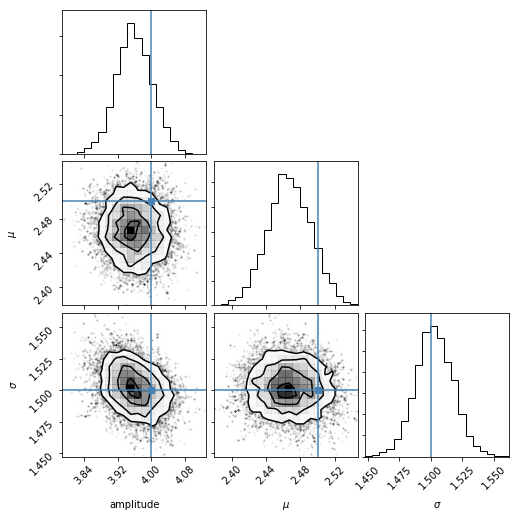

In [132]:
fig = corner.corner(samples, labels=["amplitude", "$\mu$", "$\sigma$"],
                      truths=[amp_true, mean_true, stddv_true])
fig.savefig("triangle.png")

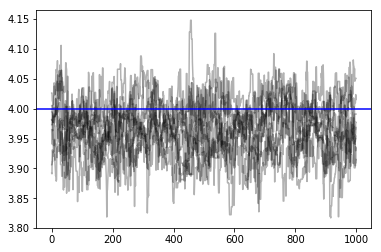

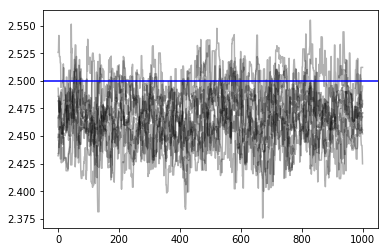

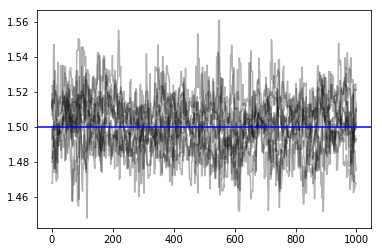

In [79]:
res=plt.plot(sampler.chain[:,:,0].T, '-', color='k', alpha=0.3)
plt.axhline(amp_true, color='blue')
plt.show()

res=plt.plot(sampler.chain[:,:,1].T, '-', color='k', alpha=0.3)
plt.axhline(mean_true, color='blue')
plt.show()

res=plt.plot(sampler.chain[:,:,2].T, '-', color='k', alpha=0.3)
plt.axhline(stddv_true, color='blue')
plt.show()